In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# get the correct colors for the different scenarios
from analysis_func import color_scenario, label_scenario, provide_reg_full_name_dict, color_scenario_poster

palette = sns.color_palette(color_scenario.values())
import geopandas as gpd


In [2]:
opt = 'last_3m_driest_month_seasonal_avg_within_melt_months'
bc = 'bc_1980_2019'

In [3]:

label_scenario_david = {'stab_T12': '1.2°C Stabilisation',
 'oversh_T30OS15': r'3.0$\rightarrow$1.5°C Overshoot',
 'stab_T15': r'1.5°C Stabilisation',
 'stab_T30': r'3.0°C Stabilisation'}
scenario_ls = {'stab_T12': '-',
 'stab_T15': '-',
 'oversh_T30OS15': '--',
 'stab_T30': '-'}
scenarios = ['stab_T15', 'stab_T30', 'oversh_T30OS15']
list_color_scenario_poster_new_order = [(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
                                        (0.8, 0.47058823529411764, 0.7372549019607844),
                                        (0.8352941176470589, 0.3686274509803922, 0.0)]
list_style = ['-','--']

In [4]:
#### glacier mass/volume
df_scenario_common_basin = xr.open_dataset(f'common_running_sum_all_basins_oversh_stab_2000_2500_bc_1980_2019.nc')
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
f = open('/home/www/lschuster/provide/provide_glacier_regions/basin_ids_per_provide_region.json')
basins_per_preg = json.load(f)

pd_vol_scenario_rel_common_basin = (100*df_scenario_common_basin/df_scenario_common_basin.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
pd_vol_scenario_rel_common_basin = pd_vol_scenario_rel_common_basin.loc[pd_vol_scenario_rel_common_basin.bias_correction==bc]
pd_vol_scenario_rel_common_basin['stab_vs_oversh'] = 'oversh'
pd_vol_scenario_rel_common_basin.loc[pd_vol_scenario_rel_common_basin['scenario'].apply(lambda x: 'stab' in x).values, 'stab_vs_oversh'] = 'stab'


In [5]:
# climate datata
pd_clim_basin_new = pd.read_csv('../annual_basin_glacier_mask_temp_precip_timeseries_oversh_stab.csv', index_col=0)

pd_basins_arid_glac_num_all = pd.read_csv('seven_arid_basins_all_stats_06_2024.csv', index_col=0)
### runoff stuff
pd_runoff_dry3m_scenario_rel_basin = pd.read_csv('seven_arid_basins_runoff_2000_2500_06_2024.csv', index_col=0)
pd_basins_arid_glac_num_all = pd_basins_arid_glac_num_all.rename(columns={'RIVER_BASI.1':'RIVER_BASIN'})

In [6]:
sel_month_to_name_dict={}
months_n = 'NDJFMAMJJASOND'
ms = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for j in np.arange(0,12,1):
    sel_month_to_name_dict[ms[j]+1] = months_n[ms[j]] + months_n[ms[j+1]] + months_n[ms[j+2]]


In [7]:
pd_basins_arid_glac_num_all.RIVER_BASIN

RIVER_BASI
INDUS                                            INDUS
SANTA                                            SANTA
YSYK-KOL (also ISSYK-KUL)    YSYK-KOL (also ISSYK-KUL)
RAPEL                                            RAPEL
TARIM HE (also TALIMU HE)    TARIM HE (also TALIMU HE)
RHONE                                            RHONE
ARAL SEA                                      ARAL SEA
Name: RIVER_BASIN, dtype: object

In [8]:
shift_b = {0:2, 1:4,2:4,3:6, 4:6, 5:8, 6:8}

INDUS trough water years all: n= 212 ; only with>=5% diff: n= 192
SANTA trough water years all: n= 201 ; only with>=5% diff: n= 182
YSYK-KOL trough water years all: n= 227 ; only with>=5% diff: n= 168
RAPEL trough water years all: n= 406 ; only with>=5% diff: n= 339
TARIM trough water years all: n= 247 ; only with>=5% diff: n= 247
RHONE trough water years all: n= 240 ; only with>=5% diff: n= 222
ARAL SEA trough water years all: n= 387 ; only with>=5% diff: n= 378


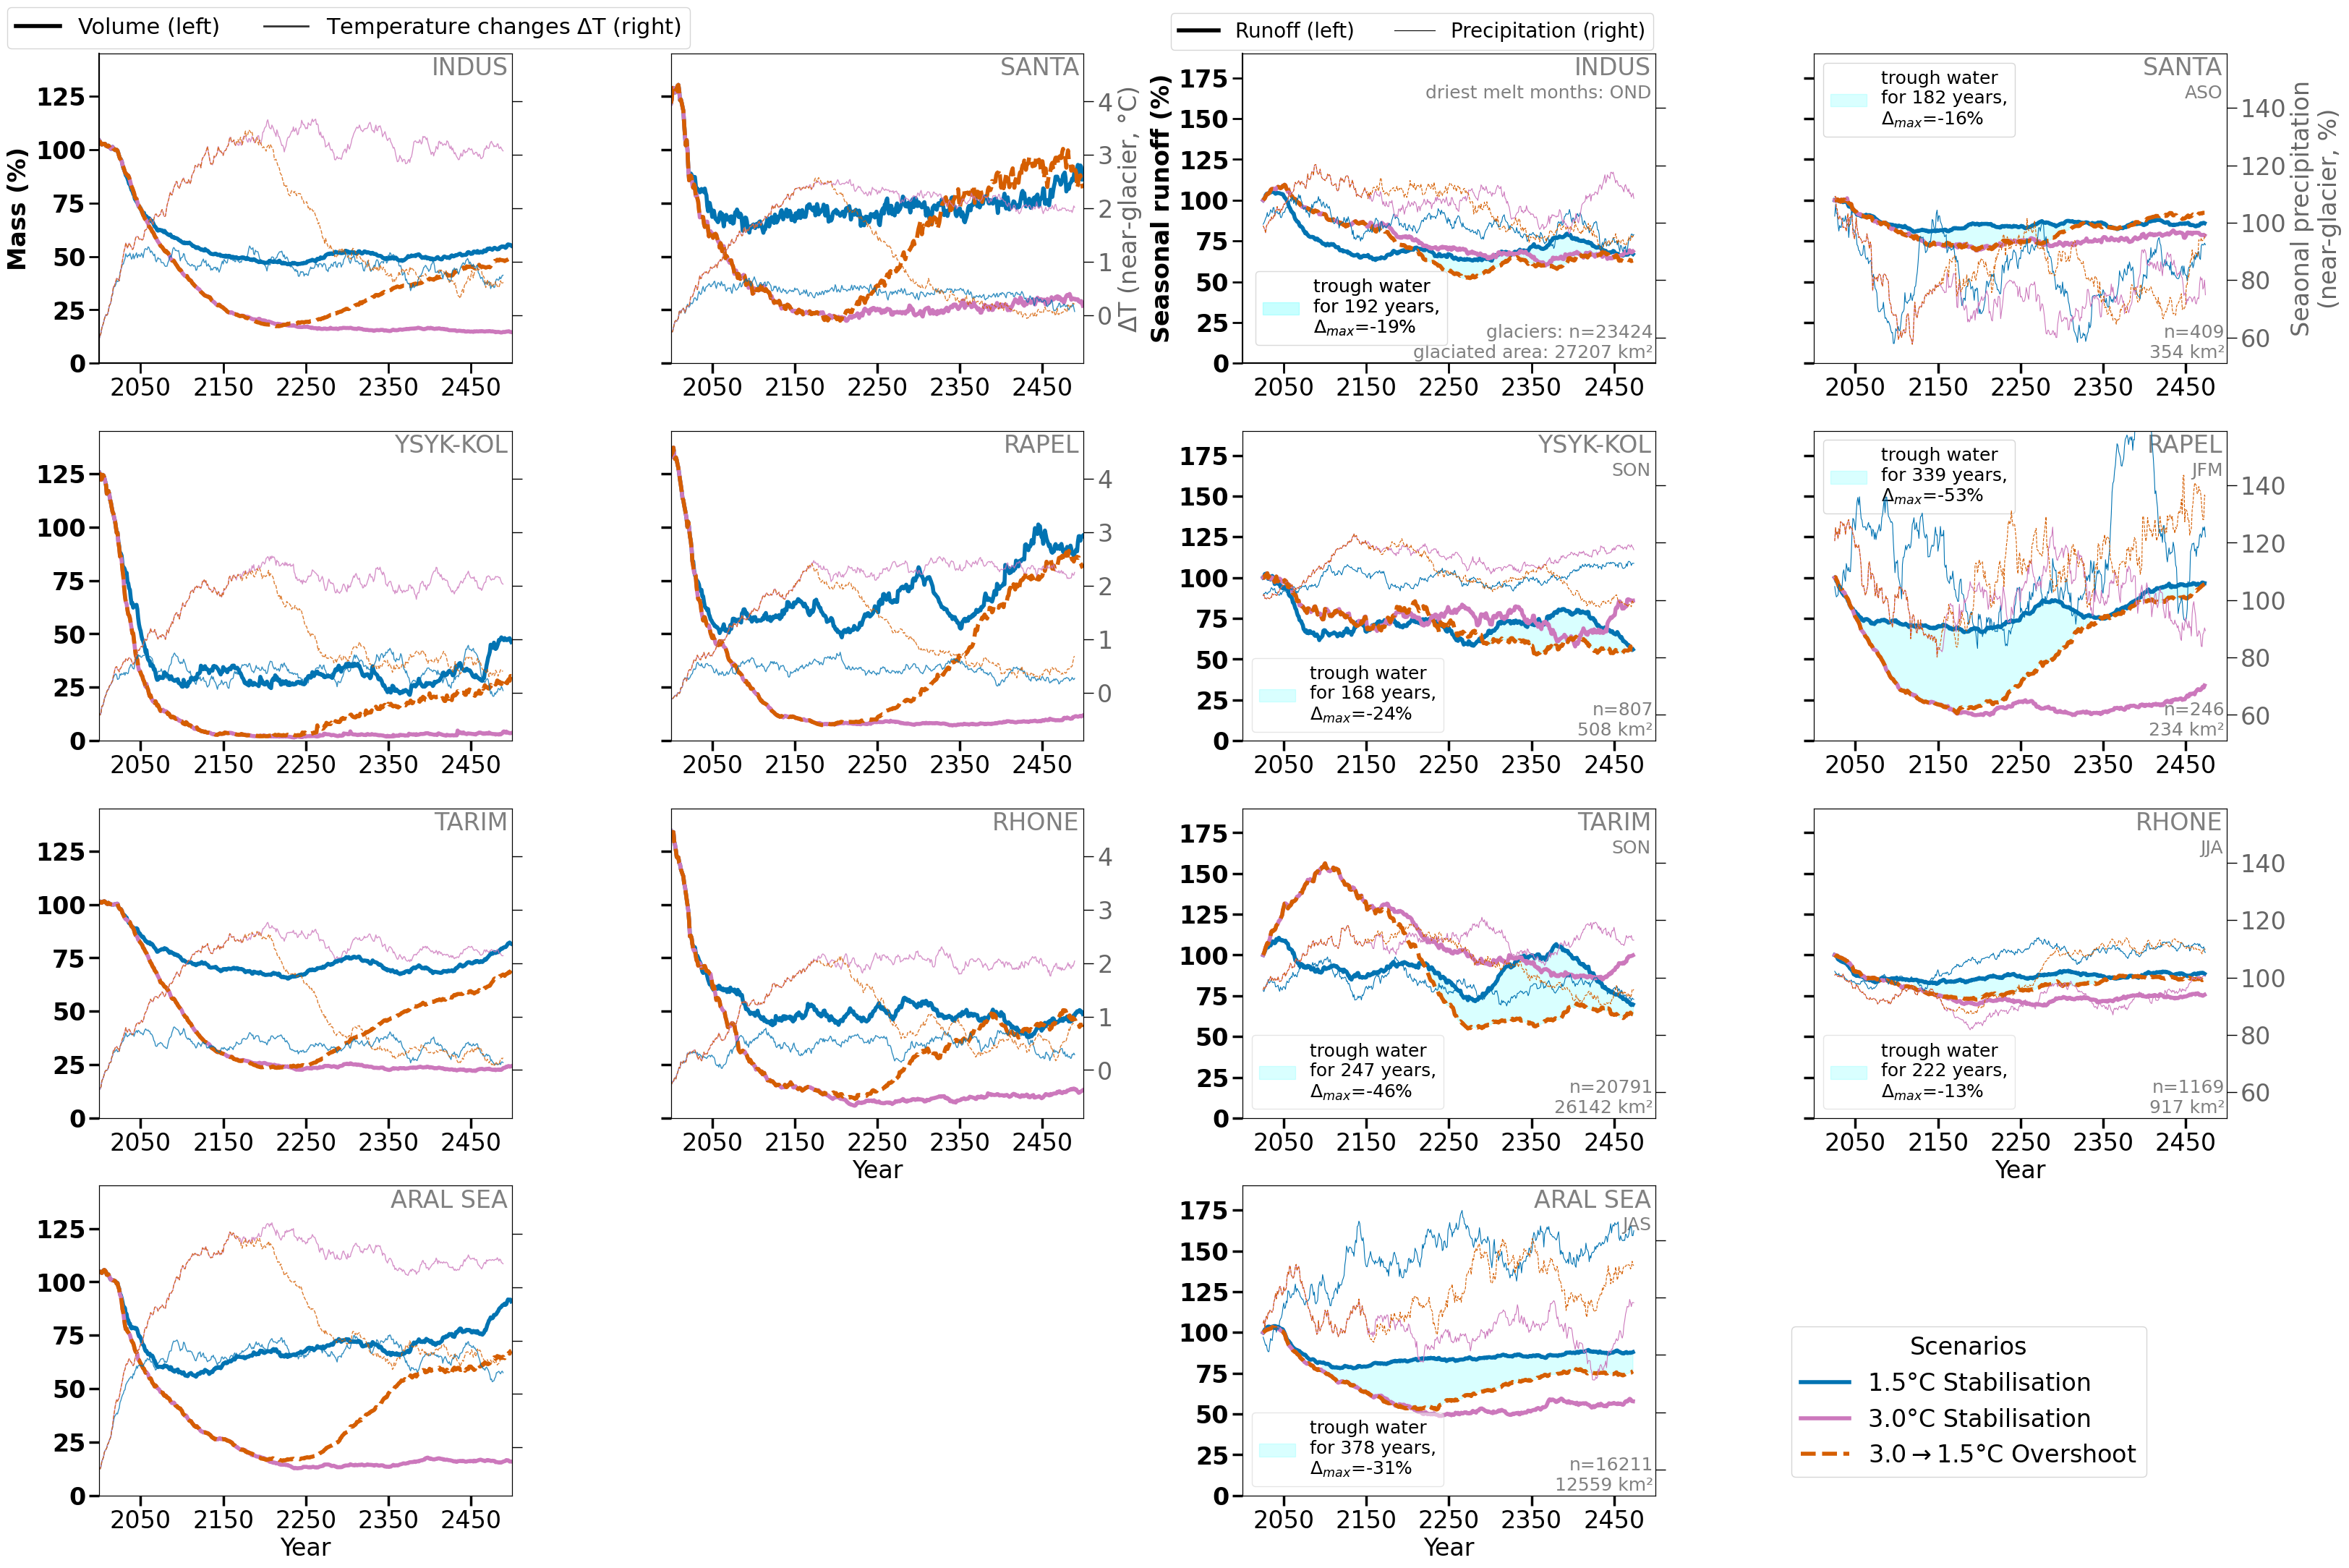

In [11]:
past_black = False
plt.rc('font', size=24)
plt.figure(figsize=(33,22)) # distances will be reduced afterwards
add_more = True
basins = pd_basins_arid_glac_num_all.MRBID.values

#shift_a = {0:2, 1:4,2:4,3:6, 4:6, 5:8, 6:8}

shift_d = {0:2, 1:4,2:4,3:6, 4:6, 5:8, 6:8}

#################### Fig. a : Mass - Temperature


var = 'temp_21yr_avg'
plt.subplot(4,4,1)
ax = plt.gca()

basin = basins[0]
basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()#[0]
continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
#basin_name = f'{continent_n}: {basin_n}'
basin_name = f'{basin_n}'

#ax.set_title(basin_name)
sns.lineplot(data=pd_vol_scenario_rel_common_basin.loc[pd_vol_scenario_rel_common_basin.basin == str(basin)],
             hue='scenario', x='time', y= 'volume_rel_2020_%', 
                palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             #dashes = [(0,0),(2, 2)],
             hue_order = scenarios, 
             lw=4, legend=True,
             ax = ax)
#ax.set_xlabel('Year')
#ax.grid(axis='x')
plt.ylabel(f'Mass (%)',# relative to 2020)',
           weight='bold')
ax.set_yticks(ticks=[0,25,50,75,100,125],
           labels=[0,25,50,75,100,125], weight='bold')

for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)

# set the parameters for both axis: label size in font points, the line tick line 
# width and length in pixels
ax.tick_params(axis='both', which='major', width=2, length=10)
ax2 = ax.twinx()  
for scenario in scenarios:
                #'stab_T30']:

    pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
    pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
    pd_clim_scenario_g.index = pd_clim_scenario_g.year
    temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
    if var == 'temp_21yr_avg':
        var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
    else:
        var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g

    ax2.plot(pd_clim_scenario_g.year,
             var_g_to_ref,
             alpha = 0.8, 
             ls = scenario_ls[scenario],
             lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
ax2.set_ylabel('')
if var != 'temp_21yr_avg':
    ticks = np.arange(70,131,10)
    ax2.set_yticks(ticks=ticks,
                    labels=ticks, alpha=0.6) 
else:
    ax2.set_yticks(ticks=[0,1,2,3,4,5],
               labels=[0,1,2,3,4,5], alpha=0.6)


plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
ax.set_xlabel('')
ax.set_xlim([2000,2500])
ax2.set_xlim([2000,2500])
ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

ax2.set_ylim([-0.9,4.9]);
ax.set_ylim([0,145]);

### add legends
handlesa, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
handles_2a, labels_2 = ax2.get_legend_handles_labels()
#leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], #title='Scenarios',
#                fontsize=20, title_fontsize=22,loc = 'lower left', bbox_to_anchor=(-0.02,1.11), ncol=3)
#for l in leg.get_lines():
#    l.set_linewidth(4)
ax_0 = ax    

plt.text(0.99,0.99, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=24, zorder=-1)

axs = []
for j, basin in enumerate(basins[1:]):
    basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()[0]
    if basin_n=='TARIM HE (also TALIMU HE)':
        basin_n = 'TARIM' # HE\n(also TALIMU HE)'
    elif basin_n =='YSYK-KOL (also ISSYK-KUL)':
        basin_n = 'YSYK-KOL'
    continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
    basin_name = f'{basin_n}'
    #basin_name = f'{continent_n}: {basin_n}'
    plt.subplot(4,4,j+2 + shift_d[j]-2)
    x_j = np.arange(1,20,2)
    x2_j = np.arange(0,20,2)

    ax = plt.gca()

    basin_vol_sel = pd_vol_scenario_rel_common_basin.loc[pd_vol_scenario_rel_common_basin.basin == str(basin)]
    sns.lineplot(data=basin_vol_sel,
             hue='scenario', x='time', y=  'volume_rel_2020_%',  
            palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             #dashes = [(0,0),(2, 2)],
             hue_order = scenarios, 
             lw=4, legend=False,
             ax = ax)

    #ax.set_title(f'{Preg}: {basin}')

    plt.text(0.99,0.99, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=24, zorder=-1)

    if j in x_j:
        ax.set_yticks(ticks=[0,25,50,75,100,125],
                   labels=[0,25,50,75,100,125], weight='bold')
    else:
        ax.set_yticks(ticks=[0,25,50,75,100,125],
                   labels=[0,25,50,75,100,125], alpha=0, fontsize=1) #visible=False) 
    ax.set_ylabel('')

            #plt.setp(ax.get_yticklabels(), visible=False)
     #plt.setp(ax.get_yticklabels(), visible=False)

    #ax.set_ylim([70,1439.9]);


    ax.tick_params(axis='both', which='major', width=2.5, length=10)
    ax2 = ax.twinx()  
    for scenario in scenarios:
                    #'stab_T30']:

        pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
        if var == 'temp_21yr_avg':
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
        else:
            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
        ax2.plot(pd_clim_scenario_g.year,
                 var_g_to_ref,
                 alpha = 0.8, 
                 ls = scenario_ls[scenario],
                 lw=1, color = color_scenario_poster[scenario], label=label_scenario_david[scenario])
    if var != 'temp_21yr_avg':
        ticks = np.arange(70,131,10)
        ax2.set_yticks(ticks=ticks,
                        labels=ticks, alpha=0.6)  
        ylabel = 'near-glacier precipitation \n(% relative to 2000-2019)' #, glacier-area weighted)'

    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)
        ylabel = r'$\Delta$T'+' (near-glacier, °C) ' #relative to 2000-2019\n(glacier-area weighted)'
    
    ax2.set_ylabel('')
    if j in x2_j:
        pass
        #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
    else:
        #ax2.set_yticks([])
        plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    if j == 0:
        ax2.set_ylabel(ylabel,
                      alpha = 0.6)
    #ax2.set_ylim([0,5.5]);
    ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
    ax2.set_ylim([-0.9,4.9]);
    ax.set_ylim([0,145]);
    axs.append(ax)
#plt.tight_layout()

for j,ax in enumerate(axs):
    if j>=4:
        ax.set_xlabel('Year')
    else:
        ax.set_xlabel('')




############################## Fig. b: RUNOFF - PRECIPITATION 
var = 'precip_3mdriest_avg_per_day_51yr_avg' #


plt.subplot(4,4,1+2)
ax = plt.gca()

#ax.set_ylabel('runoff of 3 driest melt months\n(% relative to 2000-2050)', weight='bold')
ax.set_ylabel('Seasonal runoff (%)', weight='bold')

basin = basins[0]
basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()#[0]
n_glaciers = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'n glaciers'].values[0]
glac_area = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'RGI_AREA'].values.round(0))

continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
#basin_name = f'{continent_n}: {basin_n}'
basin_name = f'{basin_n}'
sel_month = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['last_3m_driest_month_seasonal_avg'].values)
basin_name_2 = f'driest melt months: {sel_month_to_name_dict[sel_month]}'
#ax.set_title(basin_name)


sns.lineplot(data=pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin],
             hue='scenario', x='time', y= 'runoff_dry3m_rel_2000_2050_%', 
             palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             #dashes = [(0,0),(2, 2)],
             hue_order = scenarios, 
             lw=4, legend=True,
             ax = ax)

if past_black:
    sns.lineplot(data=pd_runoff_dry3m_scenario_rel_basin.loc[(pd_runoff_dry3m_scenario_rel_basin.basin == basin)&
                                                             (pd_runoff_dry3m_scenario_rel_basin.time<2020)],
                 hue='scenario',
                 x='time', y= 'runoff_dry3m_rel_2000_2050_%', 
                 color='black',
                 #dashes = [(0,0),(2, 2)],
                 #hue_order = scenarios, 
                 lw=4, legend=False,
                 ax = ax)

ax.set_yticks(ticks=np.arange(0,250,25),
              labels=np.arange(0,250,25), weight='bold')

for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)

# set the parameters for both axis: label size in font points, the line tick line 
# width and length in pixels
ax.tick_params(axis='both', which='major', width=2, length=10)
ax.set_xlabel('')
ax.set_xlim([2000,2500])

ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

#ax.set_ylim([57,125]);
#ax.set_ylim([45,150]);
ax.set_ylim([0,190]);

if add_more:
    ax2 = ax.twinx()  
    for scenario in scenarios:
                    #'stab_T30']:
        pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        precip_ref_g = pd_clim_scenario_g.loc[2000:2019]['precip_3mdriest_avg_per_day'].mean()
        #var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
        #precip_ref_g = pd_clim_scenario_g[var].dropna().iloc[0]

        var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
        var_g_to_ref = var_g_to_ref.loc[2025:2474] # let's just plot the same series as for runoff, otherwise confusing ...

        ax2.plot(var_g_to_ref.index,
                 var_g_to_ref,
                 alpha = 1, 
                 ls = scenario_ls[scenario],
                 lw=0.8, color = color_scenario[scenario], label=label_scenario_david[scenario])
    ax2.set_ylabel('')
    if var != 'temp_21yr_avg':
        #ticks = np.arange(80,131,20)
        ticks = np.arange(60,151,20)
        ax2.set_yticks(ticks=ticks,
                        labels=ticks, alpha=0.6) 
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)

    plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)


    ax2.set_ylim([51,159]);
    handles_2, labels_2 = ax2.get_legend_handles_labels()


### add legends
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
if add_more:
    leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], #title='Scenarios',
                    fontsize=18, title_fontsize=22,loc = 'lower left', bbox_to_anchor=(-0.02,1.11), ncol=3)
    for l in leg.get_lines():
        l.set_linewidth(4)


    leg2 = ax.legend([handles[1], handles_2[0]], ['Runoff (left)', # #, 51-yr avg.)',
                                                  f'Precipitation (right)'], #, 51-yr avg.)'],
                     loc='lower right', fontsize=20, bbox_to_anchor=(1.02,0.98), ncol=2)
    leg2.get_lines()[0].set_linewidth(4)
    leg2.get_lines()[1].set_linewidth(0.8)
    for l in leg2.get_lines():
        l.set_color('black')
    # let's not show again the legend ...
    #ax.add_artist(leg)

ax.text(0.99,0.99, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=24, zorder=-1)
ax.text(0.99,0.9,
         basin_name_2,transform=ax.transAxes,ha='right',va='top',
         color='grey', fontsize=18, zorder=-1)

ax.text(0.995,0.005, f'glaciers: n={n_glaciers}\nglaciated area: {glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=18, zorder=-1)
if add_more:
    y0,y1 = pd_basins_arid_glac_num_all['trough_water_pot_start_end'].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().split('_')
    pd_basin_sel = pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin].dropna()
    pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
    pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
    pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
    pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time

    nyears,water_trough_max_diff  = pd_basins_arid_glac_num_all[['yrs_with_trough_water',
                                                        'trough_water_max_diff']].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().values

    water_trough_max_diff = np.round(float(water_trough_max_diff),0)
    add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
    condi_5perc = (pd_basin_sel_oversh_T30OS15_runoff['runoff_dry3m_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_dry3m_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
    # pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
    ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time.where(condi_5perc), 
                     pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc), 
                     pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc),
                     alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
    print(basin_name, 'trough water years', 'all: n=', len(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].dropna()), 
          '; only with>=5% diff: n=',
          len((pd_basin_sel_oversh_T30OS15_runoff['runoff_dry3m_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_dry3m_rel_2000_2050_%']).loc[float(y0):float(y1)+1].where(condi_5perc).dropna()))
    handles_x, labels_x = ax.get_legend_handles_labels()
    leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc='lower left',bbox_to_anchor=(0.01,0.03),fontsize=18, framealpha = 0.5)
    ax.add_artist(leg3)
ax_b0 = ax


axs = []
for j, basin in enumerate(basins[1:]):
    basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()[0]
    n_glaciers = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'n glaciers'].values[0]
    glac_area = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'RGI_AREA'].values.round(0))
    if basin_n=='TARIM HE (also TALIMU HE)':
        basin_n = 'TARIM' # HE\n(also TALIMU HE)'
    elif basin_n =='YSYK-KOL (also ISSYK-KUL)':
        basin_n =  'YSYK-KOL'
    continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
    basin_name = f'{basin_n}'
    sel_month = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)][opt].values)
    basin_name_2 = f'{sel_month_to_name_dict[sel_month]}'

    plt.subplot(4,4,2+shift_d[j]+j)
    x_j = np.arange(1,20,2)
    x2_j = np.arange(0,20,2)

    ax = plt.gca()
    basin_runoff_sel = pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin]
    sns.lineplot(data=basin_runoff_sel,
             hue='scenario', x='time', y= 'runoff_dry3m_rel_2000_2050_%',  
             palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             hue_order = scenarios,
             lw=4, legend=False,
             ax = ax)

    plt.text(0.99,0.99, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=24, zorder=-1)
    plt.text(0.99,0.9,
         basin_name_2,transform=ax.transAxes,ha='right',va='top',
         color='grey', fontsize=18, zorder=-1)
    
    plt.text(0.995,0.005, f'n={n_glaciers}\n{glac_area} km²', #f'{n_glaciers} glaciers\n{glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=18, zorder=-1)
    ax.set_ylabel('')
    if j in x_j:
        ax.set_yticks(ticks=np.arange(0,250,25),
                   labels=np.arange(0,250,25), weight='bold')
    else:
        ax.set_yticks(ticks=np.arange(0,250,25),
                   labels=np.arange(0,250,25), alpha=0, fontsize=1) #visible=False) 

    ax.tick_params(axis='both', which='major', width=2.5, length=10)
    
    if add_more:
        ax2 = ax.twinx()  
        for scenario in scenarios:

            pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            precip_ref_g = pd_clim_scenario_g.loc[2000:2019]['precip_3mdriest_avg_per_day'].mean()
            #precip_ref_g = pd_clim_scenario_g[var].dropna().iloc[0]
            #var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            var_g_to_ref = var_g_to_ref.loc[2025:2474] # let's just plot the same series as for runoff, otherwise confusing ...

            ax2.plot(var_g_to_ref.index,
                     var_g_to_ref,
                     alpha = 1, 
                     ls = scenario_ls[scenario],
                     lw=0.8, color = color_scenario_poster[scenario], label=label_scenario_david[scenario])
        if var != 'temp_21yr_avg':
            ticks = np.arange(60,151,20)
            ax2.set_yticks(ticks=ticks,
                            labels=ticks, alpha=0.6)  
            ylabel = 'Seaonal precipitation\n(near-glacier, %)' #, glacier-area weighted)' 2003+/-25

        else:
            ax2.set_yticks(ticks=[0,1,2,3,4,5],
                       labels=[0,1,2,3,4,5], alpha=0.6)
            ylabel = r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)'

        if j in x2_j:
            pass
            #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
        else:
            ax2.set_ylabel('')
            #ax2.set_yticks([])
            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
        if j == 0:
            ax2.set_ylabel(ylabel,
                          alpha = 0.6)
        #ax2.set_ylim([-0.9,5.9]);

    if j >4:
        ax.set_xlabel('Year')
    else:
        ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    ax.set_ylim([0,190]);

    if add_more:
        ax2.set_xlim([2000,2500])
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        ax2.set_ylim([51,159]);
    if add_more:
        try:
            y0,y1 = pd_basins_arid_glac_num_all['trough_water_pot_start_end'].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().split('_')
            pd_basin_sel = pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin].dropna()
            pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
            pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time

            nyears,water_trough_max_diff  = pd_basins_arid_glac_num_all[['yrs_with_trough_water',
                                                                'trough_water_max_diff']].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().values

            water_trough_max_diff = np.round(float(water_trough_max_diff),0)
            add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
            condi_5perc = (pd_basin_sel_oversh_T30OS15_runoff['runoff_dry3m_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_dry3m_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
            # pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
            # important -> keep the NaNs to show the potential incontinuoties ... 
            ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                             pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc), 
                             pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc),
                             alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
            if (basin_n == 'RAPEL') or (basin_n == 'SANTA'):
                leg_t=ax.legend(loc='upper left', fontsize=18)        
            else:
                leg_t = ax.legend(loc='lower left', fontsize=18, framealpha = 0.5)
        except:
            print(f'no trough water: {basin}')
        print(basin_name, 'trough water years', 'all: n=', len(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].dropna()), 
                  '; only with>=5% diff: n=',
                      len((pd_basin_sel_oversh_T30OS15_runoff['runoff_dry3m_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_dry3m_rel_2000_2050_%']).loc[float(y0):float(y1)+1].where(condi_5perc).dropna()))
        #if basin_name == 'INDUS':
        #    print((pd_basin_sel_oversh_T30OS15_runoff['runoff_dry3m_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_dry3m_rel_2000_2050_%']).loc[float(y0):float(y1)+1])
        
        #print(len((pd_basin_sel_oversh_T30OS15_runoff['runoff_dry3m_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_dry3m_rel_2000_2050_%']).loc[float(y0):float(y1)+1].dropna()))
    axs.append(ax)
plt.tight_layout(h_pad=0.1, w_pad=0.3, rect=[0, 0, 1, 0.98])

####
leg2a = ax_0.legend([handlesa[1], handles_2a[0]], ['Volume (left)',
                                                  r'Temperature changes $\Delta$T (right)'], #, near-glacier, 20-yr avg.)'],
                 loc='lower left', fontsize=22, bbox_to_anchor=(-0.25,0.98), ncol=2)
leg2a.get_lines()[0].set_linewidth(4)
leg2a.get_lines()[1].set_linewidth(2)
for l in leg2a.get_lines():
    l.set_color('black')
#ax.add_artist(leg)


ax_b0.add_artist(leg2)
from matplotlib.lines import Line2D
lines = []
for k in scenarios:
    line = Line2D([0], [0], label=label_scenario_david[k], color=color_scenario_poster[k], lw=4, ls = scenario_ls[k])
    lines.append(line)
axs[-2].set_xlabel('Year')
# CMIP6 overshoot GCMs and ESMs until 2300CMIP6 overshoot GCMs and ESMs until 2300
ax.legend(handles=lines, loc = 'lower left', bbox_to_anchor=(1.3,0.02), title = 'Scenarios')
ax.add_artist(leg_t)
plt.savefig(f'figures/figures_basins/3_most_arid_glaciated_basin_51yr_dry3m_avg_mass_runoff_{bc}_vs_temp_prcp_51yr_avg.png')
plt.savefig(f'figures/figures_basins/3_most_arid_glaciated_basin_51yr_dry3m_avg_mass_runoff_{bc}_vs_temp_prcp_51yr_avg.pdf')

### OLD: individual plots

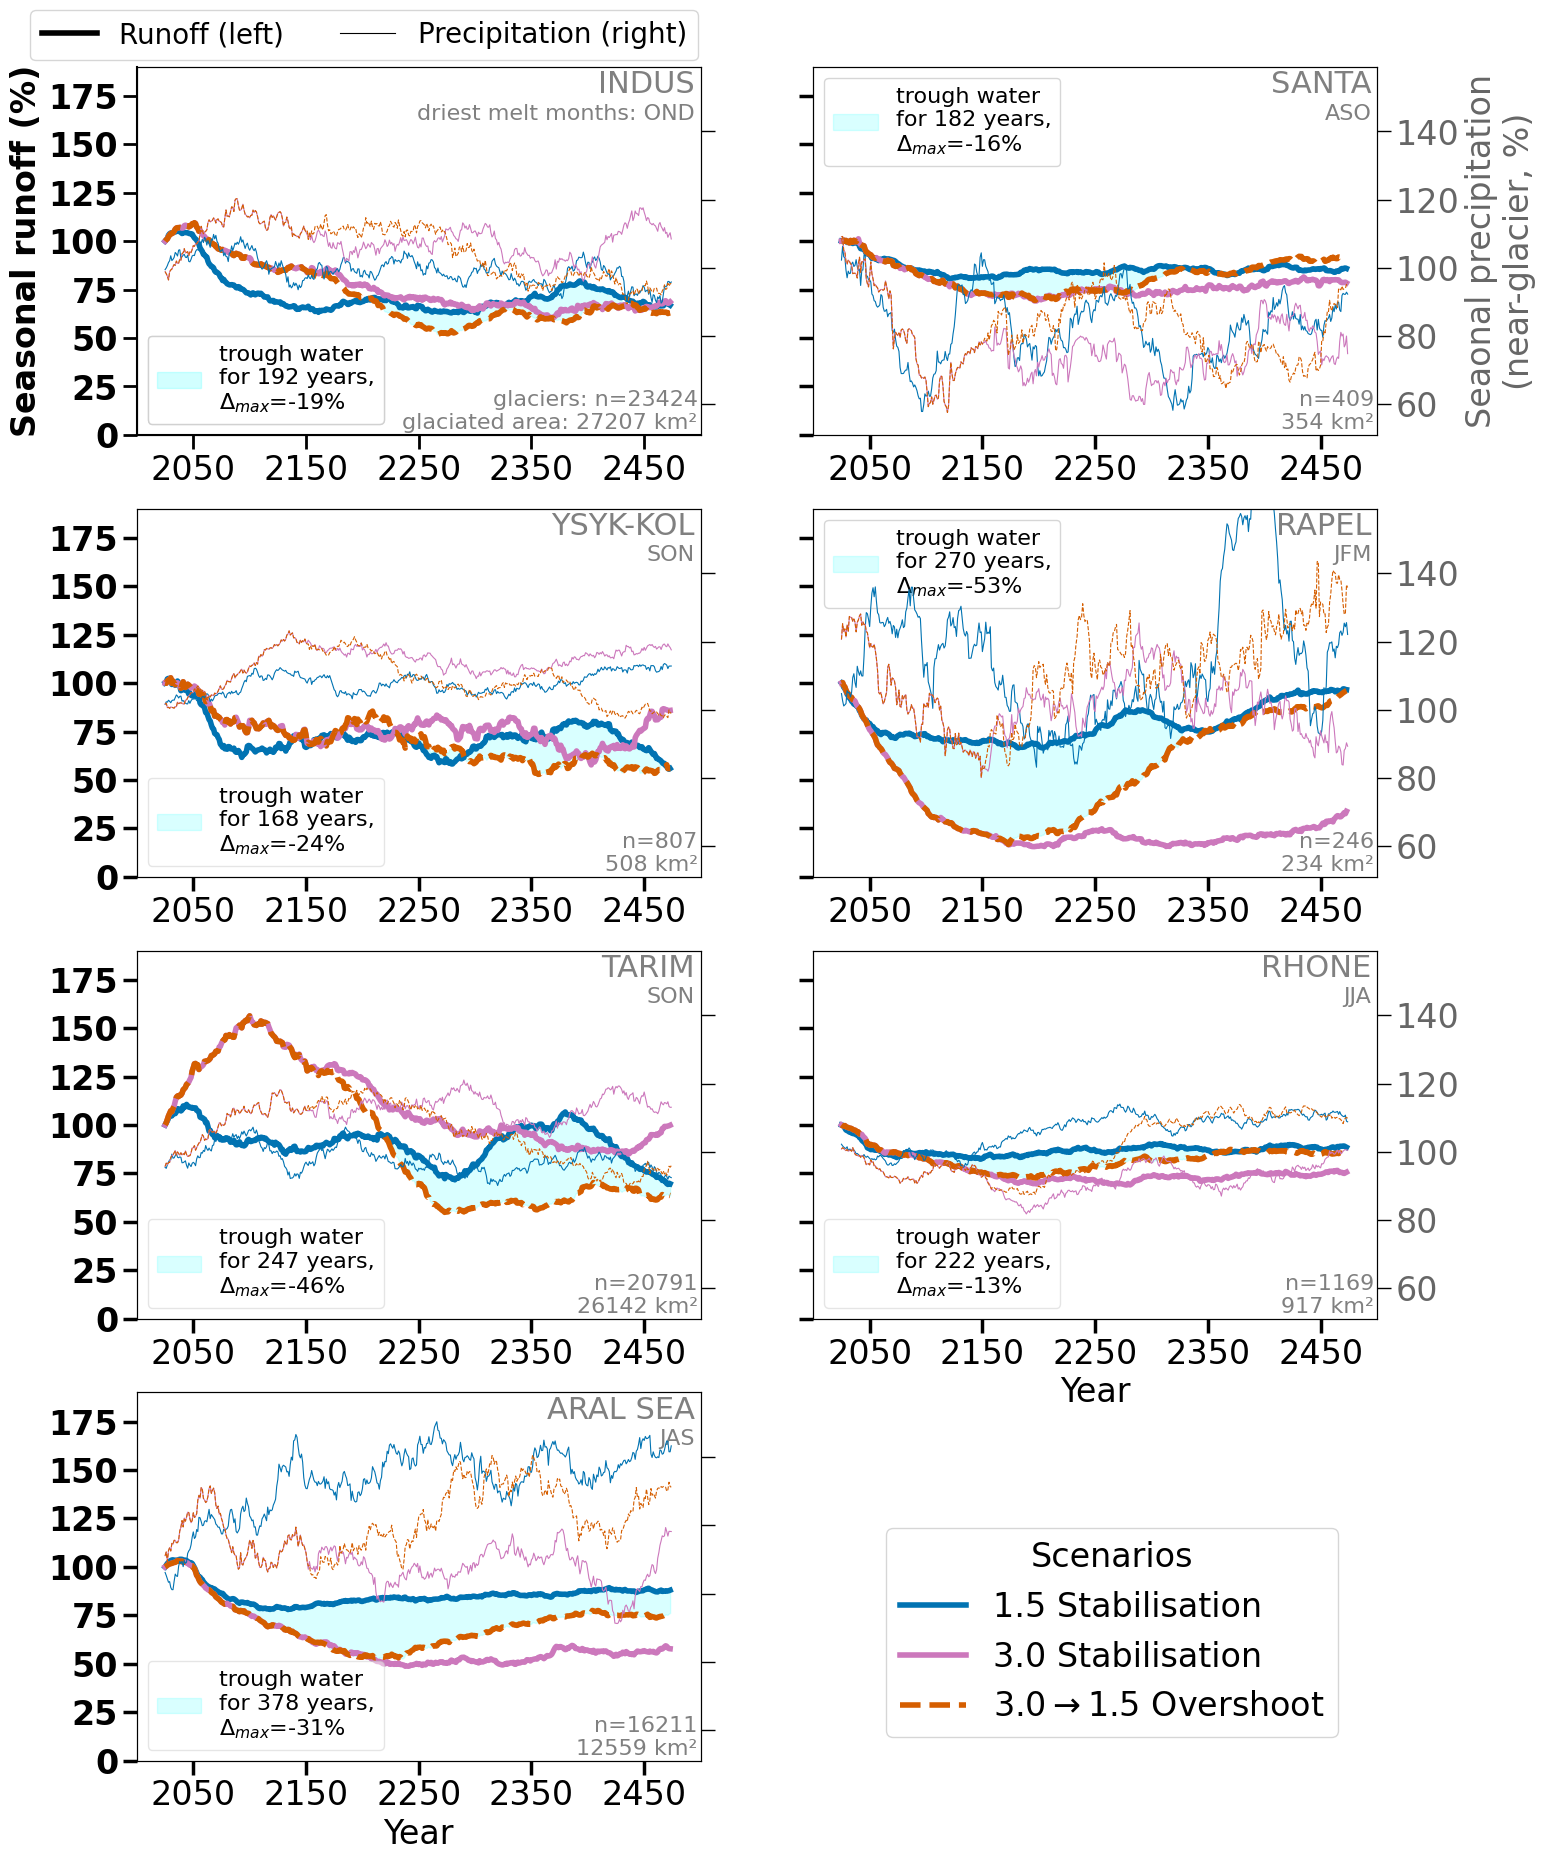

In [49]:
add_more = True
var = 'precip_3mdriest_avg_per_day_51yr_avg' #
basins = pd_basins_arid_glac_num_all.MRBID.values

plt.rc('font', size=24)

plt.figure(figsize=(16,22)) #, sharey=True, sharex=True)
plt.subplot(4,2,1)
ax = plt.gca()

#ax.set_ylabel('runoff of 3 driest melt months\n(% relative to 2000-2050)', weight='bold')
ax.set_ylabel('Seasonal runoff (%)', weight='bold')

basin = basins[0]
basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()#[0]
n_glaciers = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'n glaciers'].values[0]
glac_area = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'RGI_AREA'].values.round(0))

continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
#basin_name = f'{continent_n}: {basin_n}'
basin_name = f'{basin_n}'
sel_month = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['last_3m_driest_month_seasonal_avg'].values)
basin_name_2 = f'driest melt months: {sel_month_to_name_dict[sel_month]}'
#ax.set_title(basin_name)


sns.lineplot(data=pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin],
             hue='scenario', x='time', y= 'runoff_dry3m_rel_2000_2050_%', 
             palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             #dashes = [(0,0),(2, 2)],
             hue_order = scenarios, 
             lw=4, legend=True,
             ax = ax)



ax.set_yticks(ticks=np.arange(0,250,25),
              labels=np.arange(0,250,25), weight='bold')

for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)

# set the parameters for both axis: label size in font points, the line tick line 
# width and length in pixels
ax.tick_params(axis='both', which='major', width=2, length=10)
ax.set_xlabel('')
ax.set_xlim([2000,2500])

ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

#ax.set_ylim([57,125]);
#ax.set_ylim([45,150]);
ax.set_ylim([0,190]);

if add_more:
    ax2 = ax.twinx()  
    for scenario in scenarios:
                    #'stab_T30']:
        pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        precip_ref_g = pd_clim_scenario_g.loc[2000:2019]['precip_3mdriest_avg_per_day'].mean()
        #var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
        #precip_ref_g = pd_clim_scenario_g[var].dropna().iloc[0]

        var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
        var_g_to_ref = var_g_to_ref.loc[2025:2474] # let's just plot the same series as for runoff, otherwise confusing ...

        ax2.plot(var_g_to_ref.index,
                 var_g_to_ref,
                 alpha = 1, 
                 ls = scenario_ls[scenario],
                 lw=0.8, color = color_scenario[scenario], label=label_scenario_david[scenario])
    ax2.set_ylabel('')
    if var != 'temp_21yr_avg':
        #ticks = np.arange(80,131,20)
        ticks = np.arange(60,151,20)
        ax2.set_yticks(ticks=ticks,
                        labels=ticks, alpha=0.6) 
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)

    plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)


    ax2.set_ylim([51,159]);
    handles_2, labels_2 = ax2.get_legend_handles_labels()


### add legends
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
if add_more:
    leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], #title='Scenarios',
                    fontsize=18, title_fontsize=22,loc = 'lower left', bbox_to_anchor=(-0.02,1.11), ncol=3)
    for l in leg.get_lines():
        l.set_linewidth(4)


    leg2 = ax.legend([handles[1], handles_2[0]], ['Runoff (left)', # #, 51-yr avg.)',
                                                  f'Precipitation (right)'], #, 51-yr avg.)'],
                     loc='lower right', fontsize=20, bbox_to_anchor=(1.02,0.98), ncol=2)
    leg2.get_lines()[0].set_linewidth(4)
    leg2.get_lines()[1].set_linewidth(0.8)
    for l in leg2.get_lines():
        l.set_color('black')
    # let's not show again the legend ...
    #ax.add_artist(leg)

ax.text(0.99,0.99, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)
ax.text(0.99,0.9,
         basin_name_2,transform=ax.transAxes,ha='right',va='top',
         color='grey', fontsize=16, zorder=-1)

ax.text(0.995,0.005, f'glaciers: n={n_glaciers}\nglaciated area: {glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=16, zorder=-1)
if add_more:
    y0,y1 = pd_basins_arid_glac_num_all['water_trough_start_end'].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().split('_')
    pd_basin_sel = pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin].dropna()
    pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
    pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
    pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
    pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time

    nyears,water_trough_max_diff  = pd_basins_arid_glac_num_all[['yrs_with_water_trough',
                                                        'water_trough_max_diff']].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().values

    water_trough_max_diff = np.round(float(water_trough_max_diff),0)
    add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
    ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time, 
                     pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'], 
                     pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'],
                     alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
    handles_x, labels_x = ax.get_legend_handles_labels()
    leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc='lower left',fontsize=16)
    ax.add_artist(leg3)
    ax.add_artist(leg2)



axs = []
for j, basin in enumerate(basins[1:]):
    basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()[0]
    n_glaciers = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'n glaciers'].values[0]
    glac_area = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin), 'RGI_AREA'].values.round(0))
    if basin_n=='TARIM HE (also TALIMU HE)':
        basin_n = 'TARIM' # HE\n(also TALIMU HE)'
    elif basin_n =='YSYK-KOL (also ISSYK-KUL)':
        basin_n =  'YSYK-KOL'
    continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
    #basin_name = f'{continent_n}: {basin_n}'
    basin_name = f'{basin_n}'
    sel_month = int(pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)][opt].values)
    basin_name_2 = f'{sel_month_to_name_dict[sel_month]}'
    
    plt.subplot(4,2,j+2)
    x_j = np.arange(1,20,2)
    x2_j = np.arange(0,20,2)

    ax = plt.gca()
    basin_runoff_sel = pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin]
    sns.lineplot(data=basin_runoff_sel,
             hue='scenario', x='time', y= 'runoff_dry3m_rel_2000_2050_%',  
             palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             hue_order = scenarios,
             lw=4, legend=False,
             ax = ax)
    #ax.set_title(f'{Preg}: {basin}')

    plt.text(0.99,0.99, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)
    plt.text(0.99,0.9,
         basin_name_2,transform=ax.transAxes,ha='right',va='top',
         color='grey', fontsize=16, zorder=-1)
    
    plt.text(0.995,0.005, f'n={n_glaciers}\n{glac_area} km²', #f'{n_glaciers} glaciers\n{glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=16, zorder=-1)
    ax.set_ylabel('')
    if j in x_j:
        #plt.ylabel(f'annual runoff\n(% relative to 2000-2050)', weight='bold')
        ax.set_yticks(ticks=np.arange(0,250,25),
                   labels=np.arange(0,250,25), weight='bold')
    else:
        ax.set_yticks(ticks=np.arange(0,250,25),
                   labels=np.arange(0,250,25), alpha=0, fontsize=1) #visible=False) 
        #plt.setp(ax.get_yticklabels(), visible=False)

    #ax.set_ylim([70,1439.9]);

    ax.tick_params(axis='both', which='major', width=2.5, length=10)
    
    if add_more:
        ax2 = ax.twinx()  
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            precip_ref_g = pd_clim_scenario_g.loc[2000:2019]['precip_3mdriest_avg_per_day'].mean()
            #precip_ref_g = pd_clim_scenario_g[var].dropna().iloc[0]
            #var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
            var_g_to_ref = var_g_to_ref.loc[2025:2474] # let's just plot the same series as for runoff, otherwise confusing ...

            ax2.plot(var_g_to_ref.index,
                     var_g_to_ref,
                     alpha = 1, 
                     ls = scenario_ls[scenario],
                     lw=0.8, color = color_scenario_poster[scenario], label=label_scenario_david[scenario])
        if var != 'temp_21yr_avg':
            ticks = np.arange(60,151,20)
            ax2.set_yticks(ticks=ticks,
                            labels=ticks, alpha=0.6)  
            ylabel = 'Seaonal precipitation\n(near-glacier, %)' #, glacier-area weighted)' 2003+/-25

        else:
            ax2.set_yticks(ticks=[0,1,2,3,4,5],
                       labels=[0,1,2,3,4,5], alpha=0.6)
            ylabel = r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)'

        if j in x2_j:
            pass
            #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
        else:
            ax2.set_ylabel('')
            #ax2.set_yticks([])
            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
        if j == 0:
            ax2.set_ylabel(ylabel,
                          alpha = 0.6)
        #ax2.set_ylim([-0.9,5.9]);

    if j >4:
        ax.set_xlabel('Year')
    else:
        ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    ax.set_ylim([0,190]);

    if add_more:
        ax2.set_xlim([2000,2500])
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        ax2.set_ylim([51,159]);
    if add_more:
        try:
            y0,y1 = pd_basins_arid_glac_num_all['water_trough_start_end'].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().split('_')
            pd_basin_sel = pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin == basin].dropna()
            pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
            pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time

            nyears,water_trough_max_diff  = pd_basins_arid_glac_num_all[['yrs_with_water_trough',
                                                                'water_trough_max_diff']].loc[pd_basins_arid_glac_num_all.MRBID==basin].squeeze().values

            water_trough_max_diff = np.round(float(water_trough_max_diff),0)
            add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
            ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time, 
                             pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'], 
                             pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'],
                             alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
            if (basin_n == 'RAPEL') or (basin_n == 'SANTA'):
                leg_t=ax.legend(loc='upper left', fontsize=16)        
            else:
                leg_t = ax.legend(loc='lower left', fontsize=16, framealpha = 0.5)
        except:
            print(f'no trough water: {basin}')
    axs.append(ax)
#plt.tight_layout()

from matplotlib.lines import Line2D
lines = []
for k in scenarios:
    line = Line2D([0], [0], label=label_scenario_david[k], color=color_scenario_poster[k], lw=4, ls = scenario_ls[k])
    lines.append(line)
axs[-2].set_xlabel('Year')
ax.legend(handles=lines, loc = 'lower left', bbox_to_anchor=(1.3,0.02), title = 'Scenarios')
ax.add_artist(leg_t)
plt.savefig(f'figures/figures_basins/3_most_arid_glaciated_basin_51yr_dry3m_avg_runoff_{bc}_vs_prcp_precip_51yr_avg.png')
plt.savefig(f'figures/figures_basins/3_most_arid_glaciated_basin_51yr_dry3m_avg_runoff_{bc}_vs_prcp_precip_51yr_avg.pdf')

## Fig. 4a: 

In [55]:

var = 'temp_21yr_avg'
basins = pd_basins_arid_glac_num_all.MRBID.values

plt.rc('font', size=24)

plt.figure(figsize=(16,22)) #, sharey=True, sharex=True)
plt.subplot(4,2,1)
ax = plt.gca()


basin = basins[0]
basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()#[0]
continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
#basin_name = f'{continent_n}: {basin_n}'
basin_name = f'{basin_n}'

#ax.set_title(basin_name)
sns.lineplot(data=pd_vol_scenario_rel_common_basin.loc[pd_vol_scenario_rel_common_basin.basin == str(basin)],
             hue='scenario', x='time', y= 'volume_rel_2020_%', 
                palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             #dashes = [(0,0),(2, 2)],
             hue_order = scenarios, 
             lw=4, legend=True,
             ax = ax)
#ax.set_xlabel('Year')
#ax.grid(axis='x')
plt.ylabel(f'Mass (%)',# relative to 2020)',
           weight='bold')
ax.set_yticks(ticks=[0,25,50,75,100,125],
           labels=[0,25,50,75,100,125], weight='bold')

for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)

# set the parameters for both axis: label size in font points, the line tick line 
# width and length in pixels
ax.tick_params(axis='both', which='major', width=2, length=10)
ax2 = ax.twinx()  
for scenario in scenarios:
                #'stab_T30']:

    pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
    pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
    pd_clim_scenario_g.index = pd_clim_scenario_g.year
    temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
    if var == 'temp_21yr_avg':
        var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
    else:
        var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g

    ax2.plot(pd_clim_scenario_g.year,
             var_g_to_ref,
             alpha = 0.8, 
             ls = scenario_ls[scenario],
             lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
ax2.set_ylabel('')
if var != 'temp_21yr_avg':
    ticks = np.arange(70,131,10)
    ax2.set_yticks(ticks=ticks,
                    labels=ticks, alpha=0.6) 
else:
    ax2.set_yticks(ticks=[0,1,2,3,4,5],
               labels=[0,1,2,3,4,5], alpha=0.6)


plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
ax.set_xlabel('')
ax.set_xlim([2000,2500])
ax2.set_xlim([2000,2500])
ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

ax2.set_ylim([-0.9,4.9]);
ax.set_ylim([0,145]);

### add legends
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
handles_2, labels_2 = ax2.get_legend_handles_labels()
#leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], #title='Scenarios',
#                fontsize=20, title_fontsize=22,loc = 'lower left', bbox_to_anchor=(-0.02,1.11), ncol=3)
#for l in leg.get_lines():
#    l.set_linewidth(4)
ax_0 = ax    


plt.text(0.97,0.97, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)

axs = []
for j, basin in enumerate(basins[1:]):
    basin_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['RIVER_BASIN'].values[0]#.split()[0]
    if basin_n=='TARIM HE (also TALIMU HE)':
        basin_n = 'TARIM' # HE\n(also TALIMU HE)'
    continent_n = pd_basins_arid_glac_num_all.loc[pd_basins_arid_glac_num_all.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
    basin_name = f'{basin_n}'
    #basin_name = f'{continent_n}: {basin_n}'
    plt.subplot(4,2,j+2)
    x_j = np.arange(1,20,2)
    x2_j = np.arange(0,20,2)

    ax = plt.gca()

    basin_vol_sel = pd_vol_scenario_rel_common_basin.loc[pd_vol_scenario_rel_common_basin.basin == str(basin)]
    sns.lineplot(data=basin_vol_sel,
             hue='scenario', x='time', y=  'volume_rel_2020_%',  
            palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             #dashes = [(0,0),(2, 2)],
             hue_order = scenarios, 
             lw=4, legend=False,
             ax = ax)

    #ax.set_title(f'{Preg}: {basin}')

    plt.text(0.97,0.97, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)

    if j in x_j:
        ax.set_yticks(ticks=[0,25,50,75,100,125],
                   labels=[0,25,50,75,100,125], weight='bold')
    else:
        ax.set_yticks(ticks=[0,25,50,75,100,125],
                   labels=[0,25,50,75,100,125], alpha=0, fontsize=1) #visible=False) 
    ax.set_ylabel('')

            #plt.setp(ax.get_yticklabels(), visible=False)
     #plt.setp(ax.get_yticklabels(), visible=False)

    #ax.set_ylim([70,1439.9]);


    ax.tick_params(axis='both', which='major', width=2.5, length=10)
    ax2 = ax.twinx()  
    for scenario in scenarios:
                    #'stab_T30']:

        pd_clim_scenario = pd_clim_basin_new.loc[pd_clim_basin_new.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
        if var == 'temp_21yr_avg':
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
        else:
            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
        ax2.plot(pd_clim_scenario_g.year,
                 var_g_to_ref,
                 alpha = 0.8, 
                 ls = scenario_ls[scenario],
                 lw=1, color = color_scenario_poster[scenario], label=label_scenario_david[scenario])
    if var != 'temp_21yr_avg':
        ticks = np.arange(70,131,10)
        ax2.set_yticks(ticks=ticks,
                        labels=ticks, alpha=0.6)  
        ylabel = 'near-glacier precipitation \n(% relative to 2000-2019)' #, glacier-area weighted)'

    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)
        ylabel = r'$\Delta$T'+'(near-glacier, °C) ' #relative to 2000-2019\n(glacier-area weighted)'
    
    ax2.set_ylabel('')
    if j in x2_j:
        pass
        #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
    else:
        #ax2.set_yticks([])
        plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    if j == 0:
        ax2.set_ylabel(ylabel,
                      alpha = 0.6)
    #ax2.set_ylim([0,5.5]);
    ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
    ax2.set_ylim([-0.9,4.9]);
    ax.set_ylim([0,145]);
    axs.append(ax)
#plt.tight_layout()

for j,ax in enumerate(axs):
    if j>=4:
        ax.set_xlabel('Year')
    else:
        ax.set_xlabel('')

ax = ax_0
leg2 = ax.legend([handles[1], handles_2[0]], ['Volume (left)',
                                                  r'Temperature changes $\Delta$T (right)'], #, near-glacier, 20-yr avg.)'],
                 loc='lower left', fontsize=22, bbox_to_anchor=(-0.25,0.98), ncol=2)
leg2.get_lines()[0].set_linewidth(4)
leg2.get_lines()[1].set_linewidth(2)
for l in leg2.get_lines():
    l.set_color('black')
#ax.add_artist(leg)
plt.savefig(f'figures/figures_basins/2_most_arid_glaciated_basin_50yr_volume_{bc}_vs_temperature.png')
plt.savefig(f'figures/figures_basins/2_most_arid_glaciated_basin_50yr_volume_{bc}_vs_temperature.pdf')


In [ ]:
#pd_clim_all = pd.read_csv('../annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')


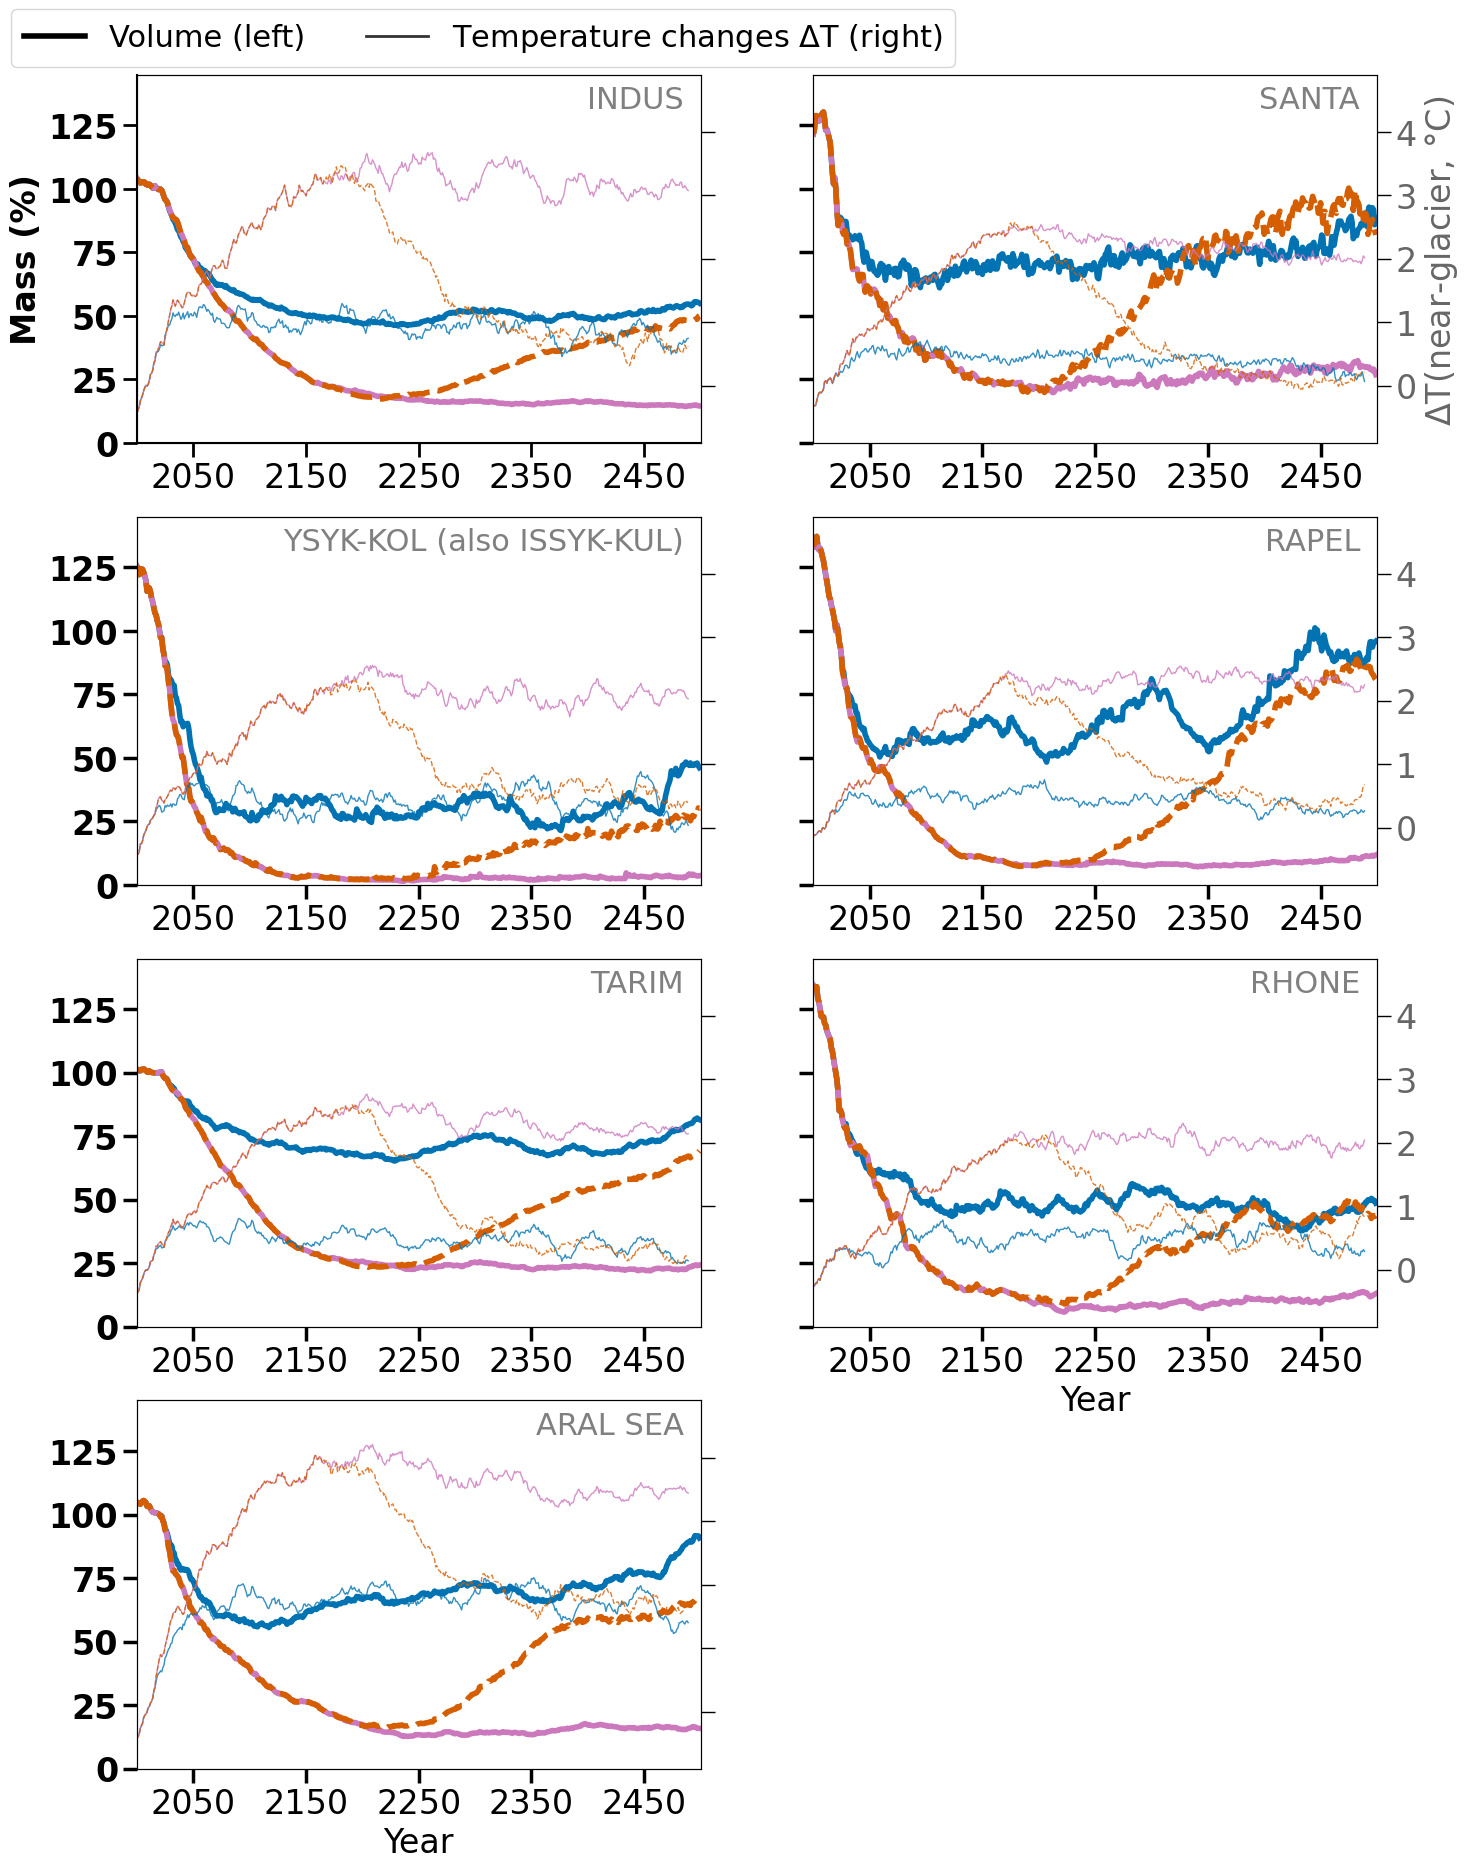

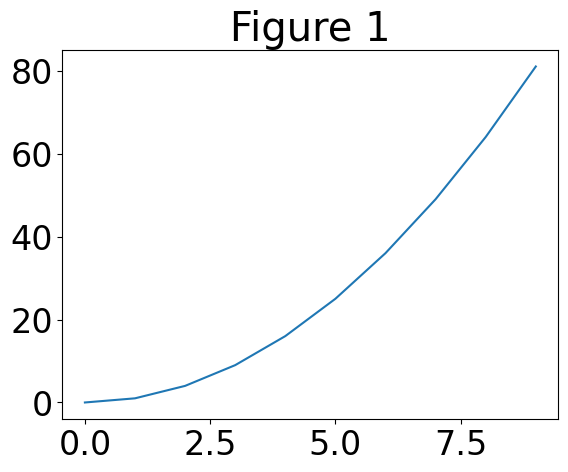

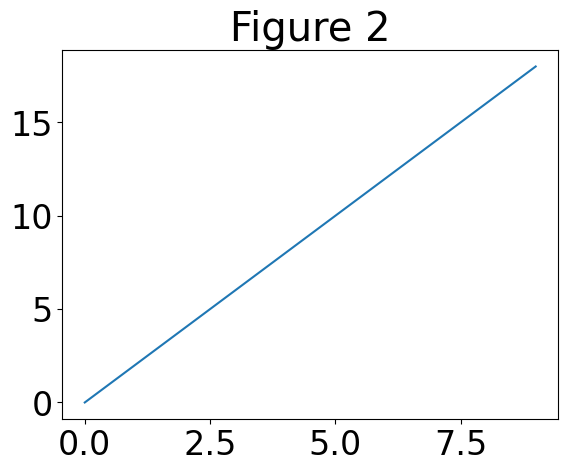

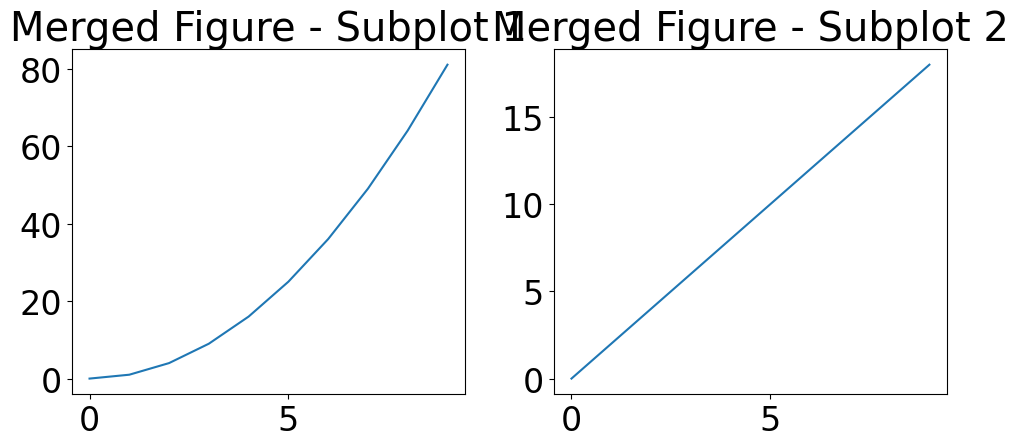

In [84]:
import matplotlib.pyplot as plt

# Example data for subplot 1
x1 = range(10)
y1 = [i**2 for i in x1]

# Example data for subplot 2
x2 = range(10)
y2 = [i*2 for i in x2]

# Create Figure 1 with subplot
fig1, ax1 = plt.subplots()
ax1.plot(x1, y1, label='Subplot 1')
ax1.set_title('Figure 1')

# Create Figure 2 with subplot
fig2, ax2 = plt.subplots()
ax2.plot(x2, y2, label='Subplot 2')
ax2.set_title('Figure 2')

# Create a new figure to merge the subplots
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 5))

# Add axes from Figure 1 to the new figure
ax3.plot(x1, y1, label='Subplot 1')
ax3.set_title('Merged Figure - Subplot 1')

# Add axes from Figure 2 to the new figure
ax4.plot(x2, y2, label='Subplot 2')
ax4.set_title('Merged Figure - Subplot 2')

# Adjust layout
plt.tight_layout()

# Show the merged figure
plt.show()